---
<span style="color:#000; font-family: 'Bebas Neue'; font-size: 2em;">Machine Learning III  Unsupervised and Network Analysis</span>

<span style="color:#f00; font-family: 'Bebas Neue'; font-size: 1.5em;">EXAMEN FINAL - PARTE II (3.5 puntos)</span>
<h4 style="color:darkblue"> Universidad Pontificia Comillas</h4>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e4/Comillas_Universidad_Pontificia_logo_%282018%29.jpg" alt="drawing" style="width:200px;"/>
<h5 style="color:black">  7 Abril 2024 - Madrid </h5>
<h5 style="color:gray"> Prof. María del Valle Varo García </h5>

---

`Yago Tobio Souto`

---

### **Problema 2: Datos de Segmentación de Clientes de Centros Comerciales**

El conjunto de datos incluye **información básica de los clientes (ID, edad, género, ingresos, puntuación de gastos). El objetivo es segmentar a estos clientes.**

Objetivos:
1. **Identificar las variables que permitan representar la segmentación en 2D.**
2. **Convertir las variables categóricas a formato numérico** usando **one-hot encoding para aplicar HAC.**
3. **Aplicar HAC (con wald linkage)** para estimar el número posible de clusters.
4. Usar **K-means y realizar un gráfico de distorsión vs K para confirmar el número de clusters.**
5. Calcular el **puntaje de silueta para diferentes valores de K (de 2 a 10) y validar la elección del número de clusters.**
6. Crear un **gráfico en 2D que muestre las categorías de datos del punto 1 con los centroides de K-means, coloreando cada punto según la etiqueta asignada por K-means, para visualizar claramente la segmentación de cada cliente.**


**Librerías**

In [1]:
# Standard library imports
import itertools
import math
import os
import sys
import time
import warnings
from collections import defaultdict

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd
from scipy import sparse as sp, stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.sparse.linalg import svds
from scipy.special import softmax
from scipy.stats import multivariate_normal

# Text and natural language processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine Learning and Data Science libraries
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay

# Graph and plot libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cbook import boxplot_stats
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import plotly.express as px

# Deep Learning libraries
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset

# Transformer models
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Utility and other specific tools
from adjustText import adjust_text
from tabulate import tabulate
from tqdm.notebook import tqdm

# Recommender systems and specific utilities
import cornac
from cornac.data.text import BaseTokenizer
from cornac.data import GraphModality, ImageModality, TextModality, text as cornac_text
from cornac.datasets import amazon_clothing, filmtrust, movielens
from cornac.eval_methods import RatioSplit
from cornac.models import BPR, BaselineOnly, CTR, ItemKNN, MF, NMF, PMF, SVD, SoRec, UserKNN, VBPR, WMF
from cornac.utils import cache
#from cornac.datasets.python_splitters import python_random_split
#from cornac.models.cornac.cornac_utils import predict_ranking

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

#from recommenders.utils.timer import Timer
#from recommenders.datasets import movielens
#from recommenders.utils.notebook_utils import store_metadata
#from recommenders.models.recommenders.utils.constants import SEED
#from recommenders.datasets.python_splitters import python_random_split
#from recommenders.evaluation.python_evaluation import (
#    map,
#    ndcg_at_k,
#    precision_at_k,
#    recall_at_k,
#)

# Constants and configurations
SEED = 42
VERBOSE = False
pd.set_option("max_colwidth", 0)
%matplotlib inline

# Printing versions of libraries
print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"TensorFlow version: {tf.__version__}")

System version: 3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]
Cornac version: 2.1
TensorFlow version: 2.16.1


----
Pregunta 1: **Identificar las variables que permitan representar la segmentación en 2D.**

In [2]:
df = pd.read_csv('mall_costumers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


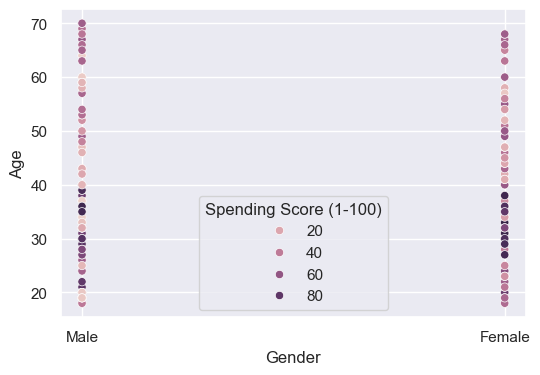

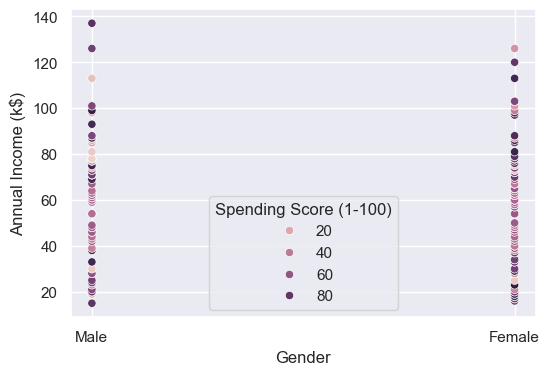

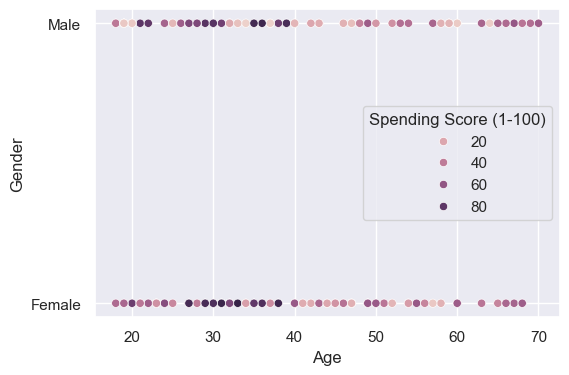

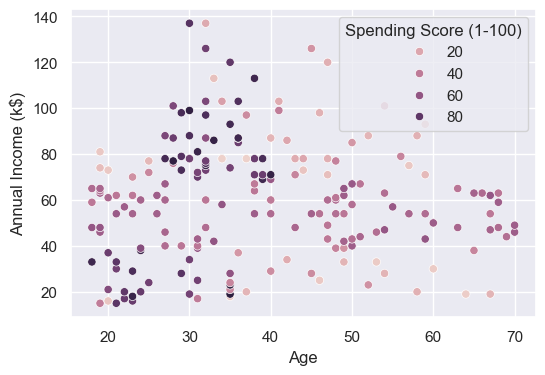

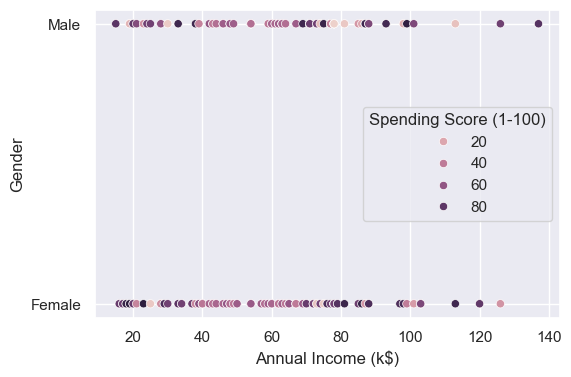

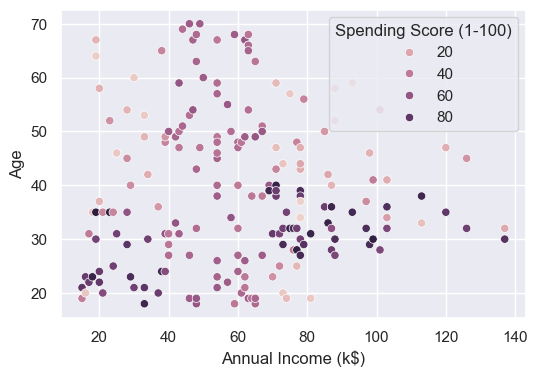

In [4]:
vars = ['Gender', 'Age', 'Annual Income (k$)']

for var_1 in vars: 
    for var_2 in vars: 
        if var_1 != var_2:
            plt.figure()
            sns.set(rc={"figure.figsize": (6, 4)})
            sns.scatterplot(df, x=var_1, y=var_2, hue="Spending Score (1-100)");

> De las variables disponibles observamos que la ideal para poder hacer un clustering son **Annual Income** vs **Age**. Ya que el objetivo es **clasificar los usuarios por Spending-Score.**

----
Pregunta 2: **Convertir las variables categóricas a formato numérico** usando **one-hot encoding para aplicar HAC.**

In [8]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Display the resulting dataframe
print(f"Encoded Employee data : \n{df_encoded}")


Encoded Employee data : 
     CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  \
0    1           19   15                  39                       
1    2           21   15                  81                       
2    3           20   16                  6                        
3    4           23   16                  77                       
4    5           31   17                  40                       
..  ..           ..   ..                  ..                       
195  196         35   120                 79                       
196  197         45   126                 28                       
197  198         32   126                 74                       
198  199         32   137                 18                       
199  200         30   137                 83                       

     Gender_Female  Gender_Male  
0    0.0            1.0          
1    0.0            1.0          
2    1.0            0.0          
3    1.0            0.

----

Pregunta 3: 3. **Aplicar HAC (con wald linkage)** para estimar el número posible de clusters.

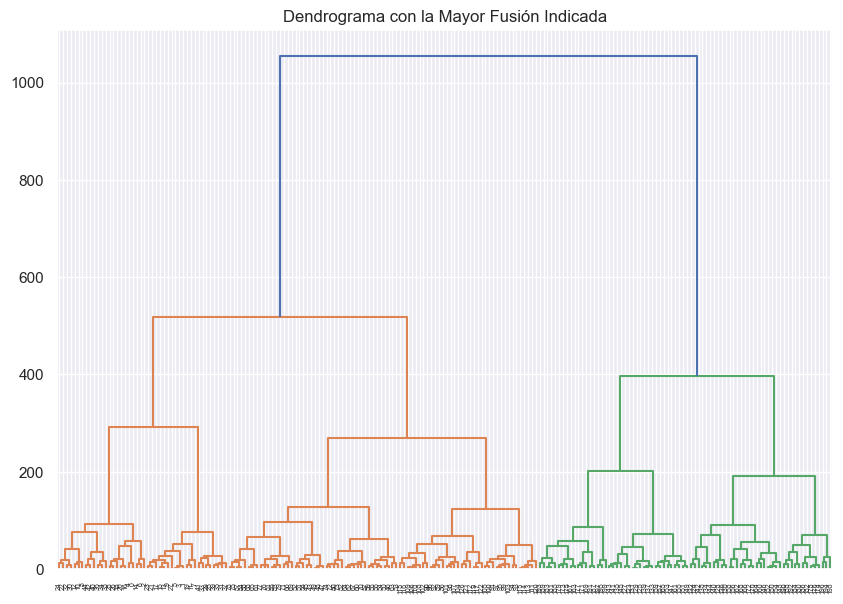

In [10]:
linked = linkage(
    df_encoded, method="ward"
)  

# labelList = range(1, 6)
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    orientation="top",
    # labels=labelList,
    distance_sort="descending",
    show_leaf_counts=True,
)
#! - plt.axhline(y=largest_increment_distance, c="k", ls="--", lw=0.5) <- Descomentar esta linea tambien si te conviene.
plt.title("Dendrograma con la Mayor Fusión Indicada")
plt.show()

----

Pregunta 4: 4. Usar **K-means y realizar un gráfico de distorsión vs K para confirmar el número de clusters.**

In [23]:
inertias = []

# Rango de valores de k para probar
k_values = range(2, 12)  # ! - Cambiar el rango

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(df_encoded) for k in k_values]

#inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(df_encoded, model.labels_) for model in kmeans_per_k]

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_encoded)
    inertias.append(kmeans.inertia_)

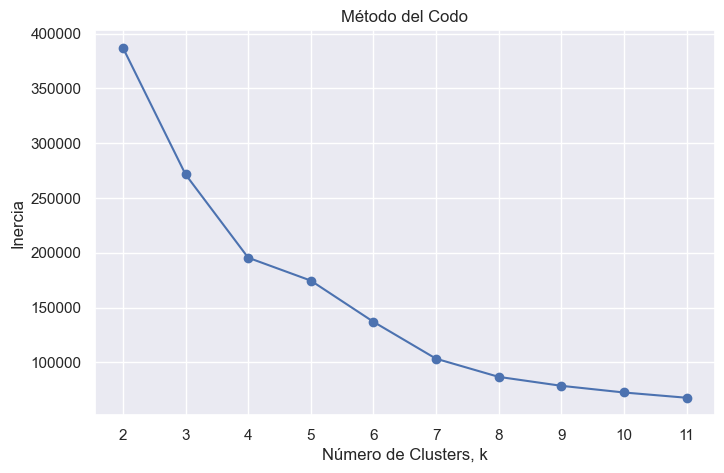

In [24]:
plt.figure(figsize=(8, 5))  # * Graficar el método del codo
plt.plot(k_values, inertias, "-o")
plt.title("Método del Codo")
plt.xlabel("Número de Clusters, k")
plt.ylabel("Inercia")
plt.xticks(k_values)
plt.show()

> El metodo del Codo indica que el numero óptimo serían 4 clusters. El cual tambien se puede confirmar al ver el dendograma en la distancia alrededor de 350.

----
Pregunta 5: Calcular el **puntaje de silueta para diferentes valores de K (de 2 a 10) y validar la elección del número de clusters.**

In [25]:
# Rango de valores de k para probar
k_values = range(2, 10)  # ! - Cambiar el rango

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(df_encoded) for k in k_values]

#inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(df_encoded, model.labels_) for model in kmeans_per_k]
silhouette_scores

[0.47926366436618395,
 0.3766163088457205,
 0.4223661897453857,
 0.42457217754930343,
 0.40999667207188506,
 0.4079392678540441,
 0.40533884718437574,
 0.39495543218496665]

In [29]:
m = max(silhouette_scores[1:]) # * Recortando simplemente la opción de 2 y 1 clusters
print("Index of the max element in a list is", silhouette_scores.index(m)+2)

Index of the max element in a list is 5


> Podemos observar que de todas las k's, a parte de k = 2, el maximo silhouette score se encuentra en K = 5 

----

**Pregunta 6:** Crear un **gráfico en 2D que muestre las categorías de datos del punto 1 con los centroides de K-means, coloreando cada punto según la etiqueta asignada por K-means, para visualizar claramente la segmentación de cada cliente.**

In [30]:
rng = np.random.RandomState(42)

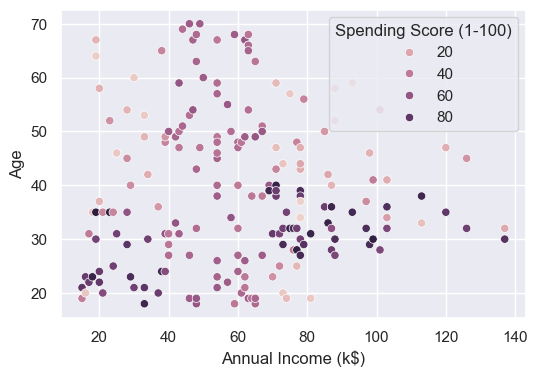

In [31]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.scatterplot(df, x='Annual Income (k$)', y='Age', hue="Spending Score (1-100)");

In [45]:
def pick_centroids(data, k):
    indexes = np.random.choice(len(data), size=k, replace=False)
    centroids = data[indexes]
    return centroids

def assign_cluster(data, centroids):
    # Pairwise squared L2 distances. Shape [n, k]
    distances = ((data[:, np.newaxis] - centroids) ** 2).sum(axis=2)
    # find closest centroid index. Shape [n]
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    # Mean positions of data within clusters
    centroids = [np.mean(data[clusters == i], axis=0) for i in range(k)]
    return np.array(centroids)

In [46]:
class KMEANS:
    def __init__(self, k):
        self.k = k

    def fit(self, data, steps=20):
        self.centroids = pick_centroids(data, self.k)
        for step in range(steps):
            clusters = assign_cluster(data, self.centroids)
            self.centroids = update_centroids(data, clusters, self.k)

    def predict(self, data):
        return assign_cluster(data, self.centroids)

In [47]:
kmeans = KMEANS(k=5)
data = df_encoded.to_numpy()
kmeans.fit(data)
clusters = kmeans.predict(data)

In [48]:
df_encoded

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,0.0,1.0
1,2,21,15,81,0.0,1.0
2,3,20,16,6,1.0,0.0
3,4,23,16,77,1.0,0.0
4,5,31,17,40,1.0,0.0
...,...,...,...,...,...,...
195,196,35,120,79,1.0,0.0
196,197,45,126,28,1.0,0.0
197,198,32,126,74,0.0,1.0
198,199,32,137,18,0.0,1.0


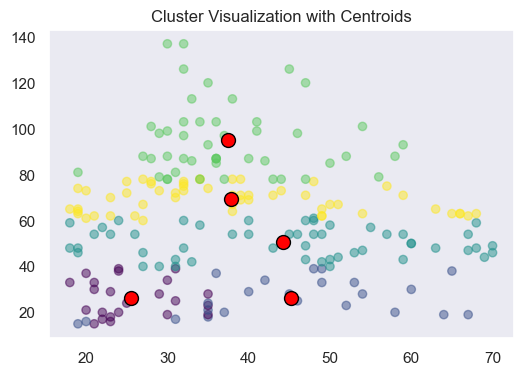

In [50]:

# * Seleccionamos las variables deseadas
plt.scatter(data[:, 1], data[:, 2], c=clusters, cmap="viridis", alpha=0.5)
plt.scatter(
    kmeans.centroids[:, 1],
    kmeans.centroids[:, 2],
    c="red",
    s=100,
    edgecolor="black",
    label="Centroids",
)
plt.title("Cluster Visualization with Centroids")
plt.grid(False)
plt.show()